In [1]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob

### Reading the Dataset

In [2]:
# unzip the dataset
#!unzip "/content/drive/MyDrive/PlantVillage_Dataset.zip" -d "/content/drive/MyDrive/"

In [4]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/PlantVillage_Dataset/train'
valid_path = '/content/drive/MyDrive/PlantVillage_Dataset/validate'

In [5]:
# download inception weights
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 0s 0us/step


In [6]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [7]:
# useful for getting number of output classes
folders = glob('/content/drive/MyDrive/PlantVillage_Dataset/train/*')

In [9]:
x = Flatten()(inception.output)
x = Dense(500, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [10]:
# summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
# tell the model what cost function and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validate_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/PlantVillage_Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 9600 images belonging to 10 classes.


In [14]:
validate_set = validate_datagen.flow_from_directory('/content/drive/MyDrive/PlantVillage_Dataset/validate',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1602 images belonging to 10 classes.


In [15]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=validate_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(validate_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
300/300 [==============================] - 155s 404ms/step - loss: 2.6130 - accuracy: 0.8191 - val_loss: 0.2324 - val_accuracy: 0.9345
Epoch 2/20
300/300 [==============================] - 125s 417ms/step - loss: 0.2716 - accuracy: 0.9173 - val_loss: 0.2492 - val_accuracy: 0.9313
Epoch 3/20
300/300 [==============================] - 128s 428ms/step - loss: 0.1957 - accuracy: 0.9401 - val_loss: 0.2633 - val_accuracy: 0.9288
Epoch 4/20
300/300 [==============================] - 120s 401ms/step - loss: 0.1596 - accuracy: 0.9484 - val_loss: 0.1415 - val_accuracy: 0.9588
Epoch 5/20
300/300 [==============================] - 119s 396ms/step - loss: 0.1259 - accuracy: 0.9555 - val_loss: 0.1654 - val_accuracy: 0.9476
Epoch 6/20
300/300 [==============================] - 120s 400ms/step - loss: 0.1162 - accuracy: 0.9630 - val_loss: 0.2222 - val_accuracy: 0.9469
Epoch 7/20
300/300 [==============================] - 121s 403ms/step - loss: 0.1027 - accuracy: 0.9641 - val_loss: 0.1798 -

In [16]:
# save it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_inception.h5')

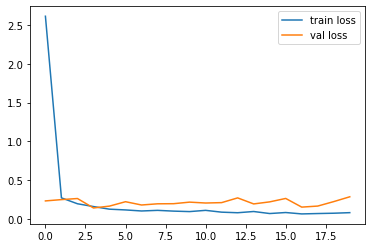

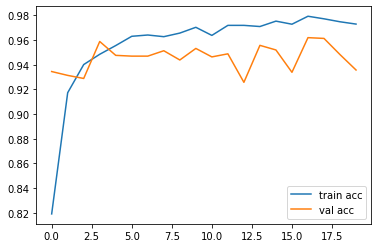

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

### Model Performance on Test Images

In [3]:
from tensorflow.keras.models import load_model
MODEL_PATH ='model_inception.h5'

# Load your trained model
model = load_model(MODEL_PATH)

In [32]:
import matplotlib.image as mpimg

def model_predict(img_path, model):
    print(img_path)
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocessing the image
    x = image.img_to_array(img)
    ## Scaling
    x=x/255
    x = np.expand_dims(x, axis=0)

    preds = model.predict(x)
    preds=np.argmax(preds, axis=1)
    if preds==0:
        preds="The leaf is a diseased Apple leaf."
    elif preds==1:
        preds="The leaf is a healthy Apple leaf."
    elif preds==2:
        preds="The leaf is a diseased Cherry leaf."
    elif preds==3:
        preds="The leaf is a healthy Cherry leaf."
    elif preds==4:
        preds="The leaf is a diseased Corn leaf."
    elif preds==5:
        preds="The leaf is a healthy Corn leaf."
    elif preds==6:
        preds="The leaf is a diseased Pepper leaf."
    elif preds==7:
        preds="The leaf is a healthy Pepper leaf."
    elif preds==8:
        preds="The leaf is a diseased Tomato leaf."
    else:
        preds="The leaf is a healthy Tomato leaf."
    
    return preds


In [33]:
def outcome_and_image(img_path, model):
    result = model_predict(img_path, model)
    img = mpimg.imread(img_path)
    print('')
    return plt.imshow(img), result

test/Apple_diseased_leaf/0bc40cc3-6a85-480e-a22f-967a866a56a1___JR_FrgE.S 2784.jpg

Result: The leaf is a diseased Apple leaf.


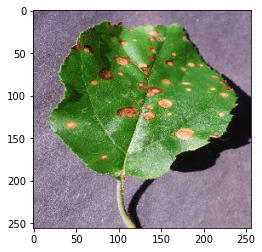

In [34]:
img_path='test/Apple_diseased_leaf/0bc40cc3-6a85-480e-a22f-967a866a56a1___JR_FrgE.S 2784.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

test/Apple_healthy_leaf/0d776b17-9724-44b9-9186-c89fd17bcf16___RS_HL 8073.jpg

Result: The leaf is a healthy Apple leaf.


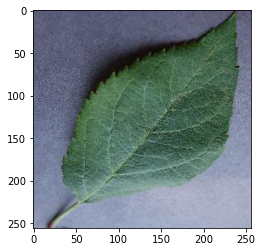

In [35]:
img_path='test/Apple_healthy_leaf/0d776b17-9724-44b9-9186-c89fd17bcf16___RS_HL 8073.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

test/Cherry_diseased_leaf/0df55dba-60e0-44e6-b64a-1f4d9a1377fd___FREC_Pwd.M 0527.jpg

Result: The leaf is a diseased Cherry leaf.


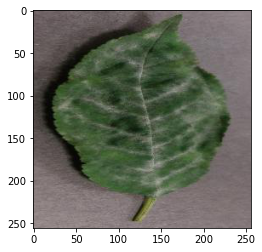

In [36]:
img_path='test/Cherry_diseased_leaf/0df55dba-60e0-44e6-b64a-1f4d9a1377fd___FREC_Pwd.M 0527.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

test/Cherry_healthy_leaf/27ab799c-5868-4386-8891-6b4ae53fa725___JR_HL 9794.jpg

Result: The leaf is a healthy Cherry leaf.


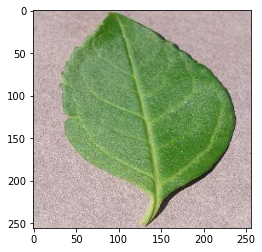

In [37]:
img_path='test/Cherry_healthy_leaf/27ab799c-5868-4386-8891-6b4ae53fa725___JR_HL 9794.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

test/Tomato_diseased_leaf/0f03a09c-aa48-4d51-95e1-752c466c3742___RS_Erly.B 6413.jpg

Result: The leaf is a diseased Tomato leaf.


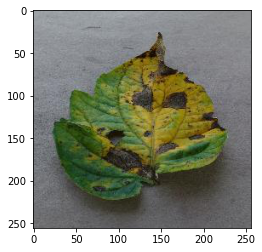

In [38]:
img_path='test/Tomato_diseased_leaf/0f03a09c-aa48-4d51-95e1-752c466c3742___RS_Erly.B 6413.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')

test/Tomato_healthy_leaf/3b0677fb-ff25-4871-aa89-37f756e917af___GH_HL Leaf 253.jpg

Result: The leaf is a healthy Tomato leaf.


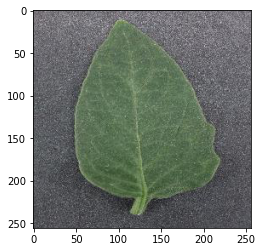

In [40]:
img_path='test/Tomato_healthy_leaf/3b0677fb-ff25-4871-aa89-37f756e917af___GH_HL Leaf 253.jpg'
im, output = outcome_and_image(img_path, model)
im
print(f'Result: {output}')